In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


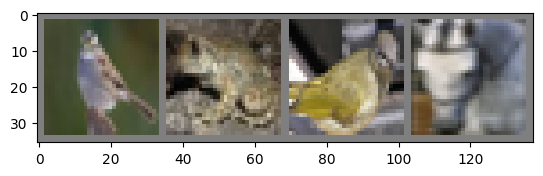

bird  frog  bird  horse


In [6]:
def imshow(img):
    img  = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [22]:
class DeepNet(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.5):
        super(DeepNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Input: 3 channels, Output: 64 filters
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: 128 filters
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Output: 256 filters
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling to reduce spatial dimensions
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size 1x1
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten for the fully connected layers
        
        # Fully connected layers with BatchNorm and Dropout
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)  # Final layer
        return F.softmax(x, dim=1)  # Apply softmax for multi-class classification

# Instantiate the simplified model
net = DeepNet(num_classes=10)  # Adjust the number of output classes if needed
print(net)


DeepNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
"""class DeepNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(DeepNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3 channels, Output: 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 32 channels, Output: 64 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 64 channels, Output: 128 filters
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Input: 128 channels, Output: 256 filters
        
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling (reduces spatial dimensions by half)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)  # Adjusted dimensions based on the final convolution output
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(p=dropout_prob)
        
        self.fc4 = nn.Linear(256, 10)  # Output for 10 classes

    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the tensor for the fully connected layers
        x = torch.flatten(x, 1)  # Flatten while keeping the batch size

        # Fully connected layers with BatchNorm, LeakyReLU, and Dropout
        x = self.bn1(self.fc1(x))
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.dropout1(x)

        x = self.bn2(self.fc2(x))
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.dropout2(x)

        x = self.bn3(self.fc3(x))
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.dropout3(x)

        x = self.fc4(x)  # Final layer (no activation here as it's handled later)
        x = F.softmax(x, dim=1)  # Apply softmax for multi-class classification
        return x

# Instantiate the model
net = DeepNet()
print(net)"""

"class DeepNet(nn.Module):\n    def __init__(self, dropout_prob=0.5):\n        super(DeepNet, self).__init__()\n\n        # Convolutional layers\n        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3 channels, Output: 32 filters\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 32 channels, Output: 64 filters\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 64 channels, Output: 128 filters\n        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Input: 128 channels, Output: 256 filters\n        \n        self.pool = nn.MaxPool2d(2, 2)  # Max pooling (reduces spatial dimensions by half)\n\n        # Fully connected layers\n        self.fc1 = nn.Linear(256 * 2 * 2, 1024)  # Adjusted dimensions based on the final convolution output\n        self.bn1 = nn.BatchNorm1d(1024)\n        self.dropout1 = nn.Dropout(p=dropout_prob)\n        \n        self.fc2 = nn.Linea

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [25]:
%%time
train_losses = []
train_accuracies = []

for epoch in range(10):  # Loop over the dataset multiple times
    running_loss = 0.0
    total = 0  # Reset total at the beginning of each epoch
    correct = 0  # Reset correct at the beginning of each epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data  # Separate the data
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = net(inputs)  # Forward step and predicting the output

        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)  # Increment total by the batch size
        correct += (predicted == labels).sum().item()  # Increment correct by the number of correct predictions

        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward propagation
        optimizer.step()  # Optimize based on the gradients

        running_loss += loss.item()

        # Print statistics every 2000 batches
        if i % 2000 == 1999:
            avg_loss = running_loss / 2000  # Average loss over 2000 batches
            avg_accuracy = 100 * correct / total  # Calculate accuracy
            train_losses.append(avg_loss)
            train_accuracies.append(avg_accuracy)
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {avg_accuracy:.2f}%')

            running_loss = 0.0  # Reset running loss
            total = 0  # Reset total for the next interval
            correct = 0  # Reset correct for the next interval
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {avg_accuracy:.2f}%')

print("Finished training")


[1, 12500] loss: 2.130, accuracy: 33.01%
[2, 12500] loss: 2.042, accuracy: 42.73%
[3, 12500] loss: 2.006, accuracy: 45.52%
[4, 12500] loss: 1.964, accuracy: 49.73%
[5, 12500] loss: 1.948, accuracy: 51.49%
[6, 12500] loss: 1.938, accuracy: 52.24%
[7, 12500] loss: 1.915, accuracy: 54.66%
[8, 12500] loss: 1.907, accuracy: 55.36%
[9, 12500] loss: 1.903, accuracy: 55.89%
[10, 12500] loss: 1.892, accuracy: 56.92%
Finished training
CPU times: user 6h 20min 46s, sys: 1min 43s, total: 6h 22min 30s
Wall time: 1h 36min 24s


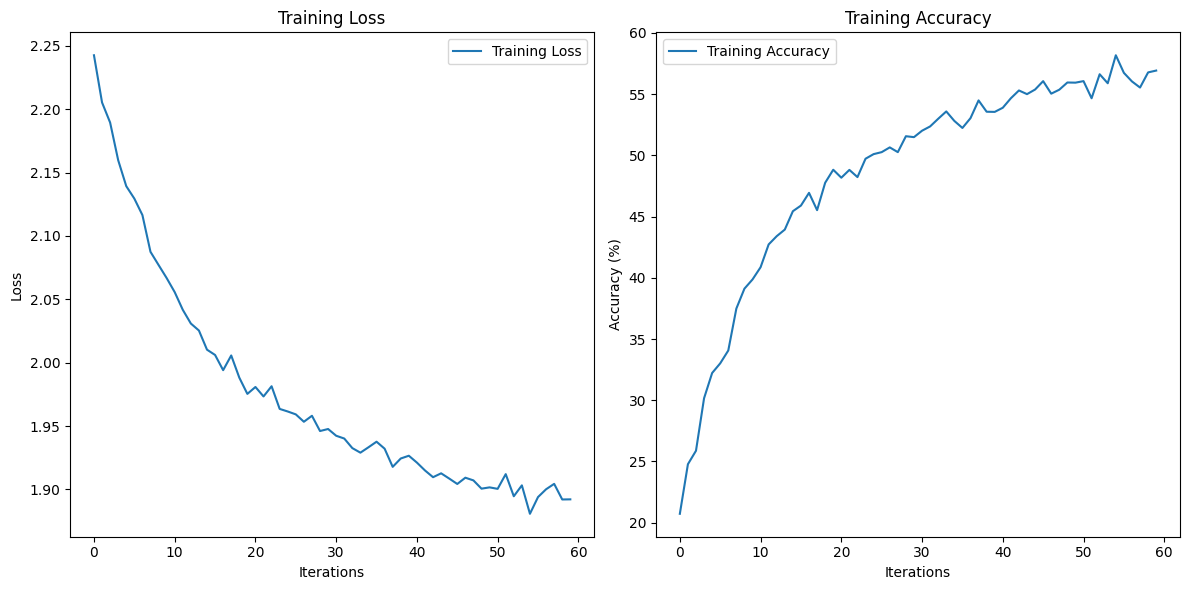

In [26]:
# Plot the training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Testing the data.

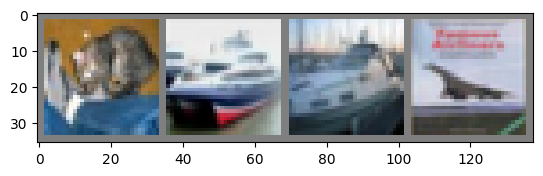

GroundTruth:  cat   ship  ship  plane


In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [30]:
net = DeepNet()
net.load_state_dict(torch.load(PATH, weights_only=True))
outputs = net(images)

In [31]:
outputs = net(images)

In [32]:
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

GroundTruth:  cat   ship  ship  plane
Predicted:  dog   car   truck plane


In [37]:
# Assuming you have initialized testloader and net (your model)
test_accuracies = []
correct = 0
total = 0
test_labels = []  # To store true labels
predicted_labels = []  # To store predicted labels

with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Forward pass
        outputs = net(images)

        # Get the predictions
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store true and predicted labels for confusion matrix
        test_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        # Calculate and store accuracy
        test_accuracy = 100 * correct // total
        test_accuracies.append(test_accuracy)

Accuracy of the network on the 10000 test images: 56 %


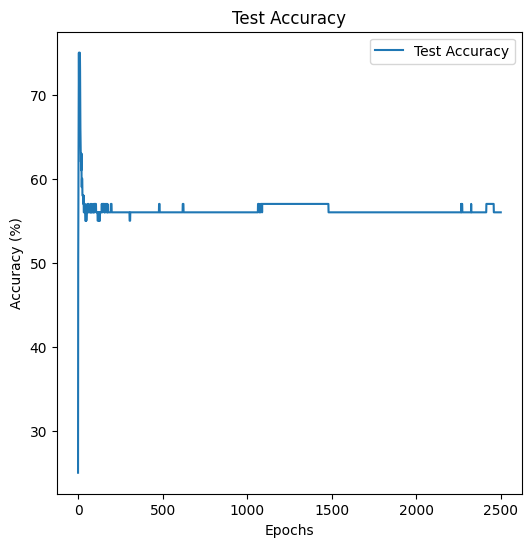

In [38]:
# Print the final accuracy
print(f'Accuracy of the network on the 10000 test images: {test_accuracy} %')

# Plot test accuracy
plt.figure(figsize=(6, 6))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

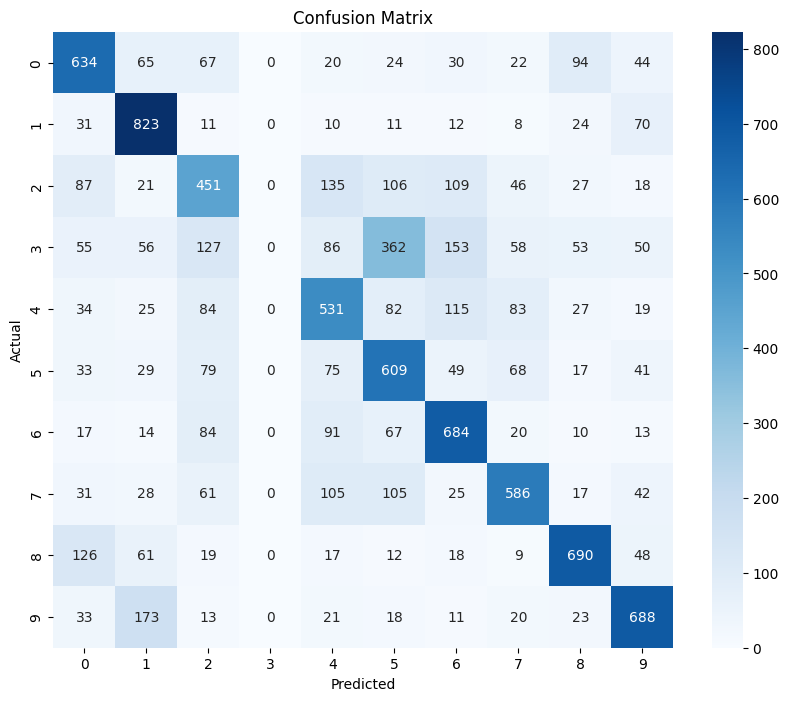

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy of the network on the 10000 test images: 56 %


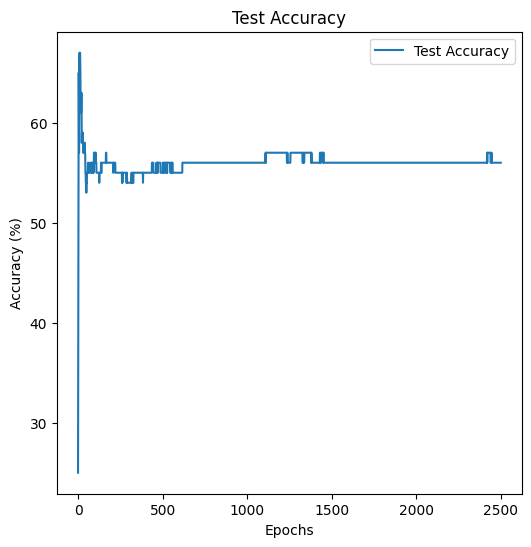

In [33]:
test_accuracies = []


correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct // total
        test_accuracies.append(test_accuracy)
        
print(f'Accuracy of the network on the 10000 test images: {test_accuracy} %')

# Plot test accuracy
plt.figure(figsize=(6, 6))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

In [36]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.9 %
Accuracy for class: car   is 81.8 %
Accuracy for class: bird  is 44.6 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 53.2 %
Accuracy for class: dog   is 61.8 %
Accuracy for class: frog  is 66.9 %
Accuracy for class: horse is 58.3 %
Accuracy for class: ship  is 69.5 %
Accuracy for class: truck is 68.4 %
